In [1]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# read StudentPerformanceFactors
raw_data = pd.read_csv('StudentPerformanceFactors.csv')
print(raw_data.shape)

(6607, 20)


In [2]:
# remove rows with missing values

cols = raw_data.columns
categorical_cols = [
    'Parental_Involvement',
    'Access_to_Resources',
    'Extracurricular_Activities',
    'Motivation_Level',
    'Internet_Access',
    'Family_Income',
    'Teacher_Quality',
    'School_Type',
    'Peer_Influence',
    'Learning_Disabilities',
    'Parental_Education_Level',
    'Distance_from_Home',
    'Gender'
]

numerical_cols = [
    'Hours_Studied',
    'Attendance',
    'Sleep_Hours',
    'Previous_Scores',
    'Tutoring_Sessions',
    'Physical_Activity',
    'Exam_Score'
]

for col in categorical_cols:
  raw_data[col] = raw_data[col].replace('', np.nan)

raw_data.dropna(inplace=True)
print(raw_data.shape)

(6378, 20)


In [3]:
!pip install xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split, GroupShuffleSplit
df = raw_data.copy()

In [4]:
# Feature Engineering
df["Internet_Access"] = df["Internet_Access"].map({"No": 0, "Yes": 1})
df["Motivation_Level"] = df["Motivation_Level"].map({"Low": 1, "Medium": 2, "High": 3})
df["Family_Income"] = df["Family_Income"].map({"Low": 1, "Medium": 2, "High": 3})
df["Teacher_Quality"] = df["Teacher_Quality"].map({"Low": 1, "Medium": 2, "High": 3})
df["School_Type"] = df["School_Type"].map({"Public": 0, "Private": 1})
df["Peer_Influence"] = df["Peer_Influence"].map({"Negative": 1, "Neutral": 2, "Postitive": 3})
df["Learning_Disabilities"] = df["Learning_Disabilities"].map({"No": 0, "Yes": 1})
df["Parental_Education_Level"] = df["Parental_Education_Level"].map({"High School": 1, "College": 2, "Postgraduate": 3})
df["Distance_from_Home"] = df["Distance_from_Home"].map({"Near": 1, "Moderate": 2, "Far": 3})
df["Gender"] = df["Gender"].map({"Female": 0, "Male": 1})
df["Extracurricular_Activities"] = df["Extracurricular_Activities"].map({"No": 0, "Yes": 1})
df["Parental_Involvement"] = df["Parental_Involvement"].map({"Low": 1, "Medium": 2, "High": 3})
df["Access_to_Resources"] = df["Access_to_Resources"].map({"Low": 1, "Medium": 2, "High": 3})

In [5]:
#shuffle the data's indices in the data set
Splitter = GroupShuffleSplit(test_size=.10, n_splits=1, random_state = 7)
#seperate indices into train and split
train_indices, Cross_Validation_indices = next(Splitter.split(df, groups=df['Exam_Score']))
#seperate x values and y values by the indices for the corss validation set
x_train_Cross_Validation = df.iloc[Cross_Validation_indices]
x_test_Cross_Validation = df.iloc[Cross_Validation_indices]
y_train_Cross_Validation = df.iloc[Cross_Validation_indices]['Exam_Score']
y_test_Cross_Validation = df.iloc[Cross_Validation_indices]['Exam_Score']
x_train_Cross_Validation.shape, x_test_Cross_Validation.shape, y_train_Cross_Validation.shape, y_test_Cross_Validation.shape

((936, 20), (936, 20), (936,), (936,))

In [6]:
#seperate the train and test indices into x and y data sets for the non hierarchical set
x_train, x_test, y_train, y_test = train_test_split(df.iloc[train_indices], df.iloc[train_indices]['Exam_Score'], test_size=0.10, random_state=48)
x_train.shape, x_test.shape, y_train.shape, y_test.shape
x_train = x_train.drop('Exam_Score', axis=1)
x_test = x_test.drop('Exam_Score', axis=1)

In [7]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
train_data = lgb.Dataset(x_train, label=y_train)
test_data = lgb.Dataset(x_test, label=y_test, reference=train_data)

In [9]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,
    'verbose': -1
}

In [10]:
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# Define model
model = LGBMRegressor(
    objective='regression',
    learning_rate=0.1,
    n_estimators=1000
)

# Fit model using callbacks
model.fit(
    x_train, y_train,
    eval_set=[(x_test, y_test)],
    eval_metric='rmse',
    callbacks=[early_stopping(stopping_rounds=10), log_evaluation(period=50)]
)

# Predict
y_pred = model.predict(x_test)

# Evaluate
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"RMSE: {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000865 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 200
[LightGBM] [Info] Number of data points in the train set: 4897, number of used features: 19
[LightGBM] [Info] Start training from score 66.937921
Training until validation scores don't improve for 10 rounds
[50]	valid_0's rmse: 2.30621	valid_0's l2: 5.31859
Early stopping, best iteration is:
[83]	valid_0's rmse: 2.26909	valid_0's l2: 5.14876
RMSE: 2.27
R² Score: 0.68


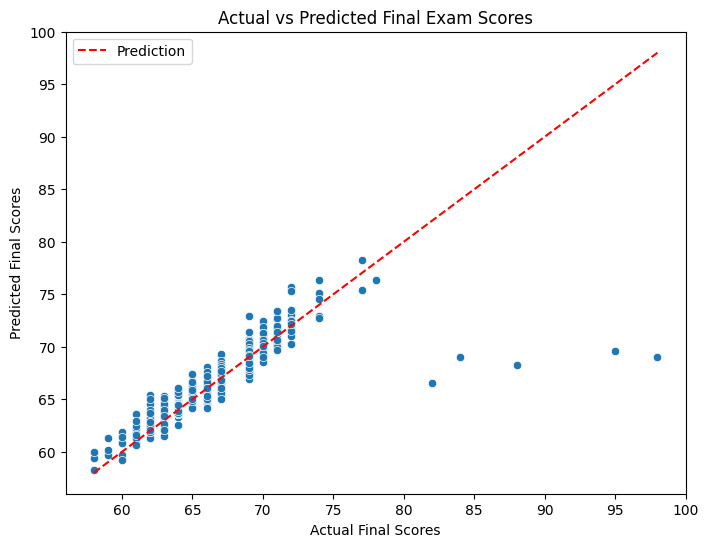

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plot of actual vs predicted values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label="Prediction")
plt.xlabel("Actual Final Scores")
plt.ylabel("Predicted Final Scores")
plt.title("Actual vs Predicted Final Exam Scores")
plt.legend()
plt.show()

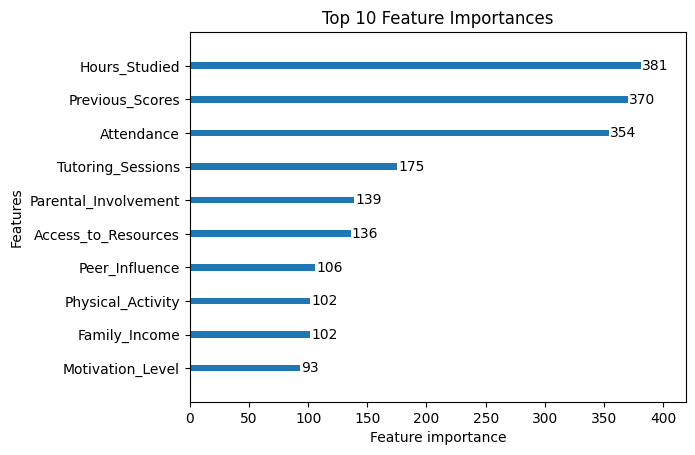

In [14]:
# Feature importance plot
lgb.plot_importance(model, max_num_features=10)
plt.title("Top 10 Feature Importances")
plt.grid(False)
plt.show()

<Figure size 32000x24000 with 0 Axes>

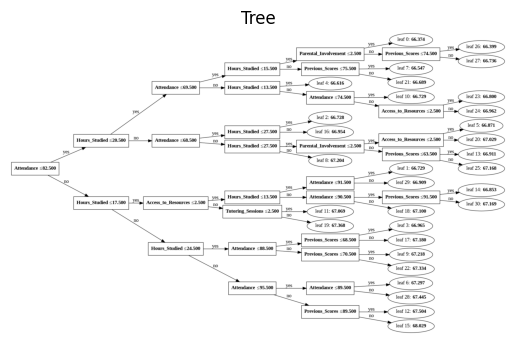

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(32, 24), dpi=1000)

lgb.plot_tree(model, tree_index=0)
plt.title("Tree")
plt.show()

<Figure size 3200x2400 with 0 Axes>

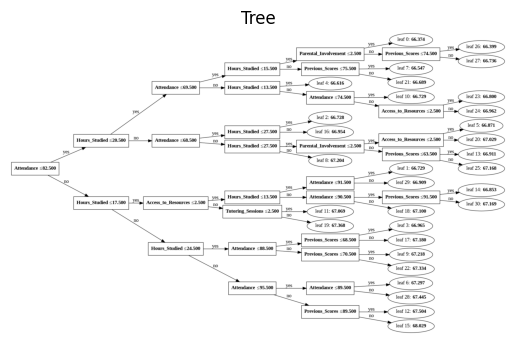

In [ ]:
plt.figure(figsize=(16, 12), dpi=200)

# Plot the first tree
lgb.plot_tree(model, tree_index=0)

plt.title("Tree")
plt.savefig("tree_plot.png", dpi=300)
plt.show()

In [ ]:
#cross validation
r2_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='r2')
rmse_scores = cross_val_score(model, x_train, y_train, cv=5, scoring='neg_mean_squared_error')
average_r2 = np.mean(r2_scores)
average_rmse = np.mean(-rmse_scores)
print(f"Average R² Score: {average_r2:.2f}")
print(f"Average RMSE: {average_rmse:.2f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 3917, number of used features: 19
[LightGBM] [Info] Start training from score 66.951493
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000693 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 3917, number of used features: 19
[LightGBM] [Info] Start training from score 66.902476
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000684 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough,